In [1]:
import sys, os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from flow import Paths
from plot import nb, ebar

Folder, _, _, Subjects = Paths.ExpData(fig_subfolder = 'behav')
c = nb.cmap() # default colourmap
ext = '.png'

Figures export: /home/kristjan/_pubs/seq_plos_cb/fig/source/behav


In [12]:
measures = ['score', 'rt_first', 'rt_last', 'rt_d']
Label = ['Novel', 'Learned']

# create array indicating whether a trial is_learned
num_trials = 72
F = np.ones((num_trials, 1), dtype=bool)
F[np.arange(2, num_trials, 3)] = False # mark novel seqs as false
F[0] = False # disregard data from the very first trial
SeqType = [Label[int(l[0])] for l in F]

B = pd.DataFrame(columns=['Trial', 'Subject', 'sec', 'Type', 'measure'])

for m in measures:
    
    # read behav data from log files
    D = pd.read_csv(os.path.join(Folder['SourceData'], 'task-gabor_meas-' + m + '.tsv'), delimiter='\t', header=None)
    SeqType = [Label[int(l[0])] for l in F]
    Y = D.stack(dropna=False).reset_index()
    Y.columns = ['Trial','Subject', 'sec']
    Y['Type'] = [i for i in SeqType for j in range(len(Y.Subject.unique()))]
    Y['measure'] = [m] * len(Y)
    
    # running average
    N = [4, 5, 6, 7, 8, 9] # window sizes
    for n in N:
        for s in Y.Subject.unique():
            label = 'R' + str(n)
            for l in Label:
                y = Y[(Y.Subject==s) & (Y.Type==l)].sec.rolling(window=n, min_periods=n-2).mean()
                Y.loc[y.index, label] = y
    
    B = B.append(Y, ignore_index=True)

In [13]:
yG = Y.groupby(['Subject', 'Type', 'measure']).mean()
yG.groupby(['Type', 'measure']).mean()

Trial       sec        R4        R5        R6        R7  \
Type    measure                                                                
Learned rt_d     35.744681  0.534728  0.536078  0.534638  0.534328  0.532906   
Novel   rt_d     35.040000  0.552890  0.558933  0.555387  0.554574  0.553056   

                       R8        R9  
Type    measure                      
Learned rt_d     0.533313  0.532098  
Novel   rt_d     0.548766  0.547425

In [ ]:
os.path.join(Folder['SourceData'], 'task-gabor_meas-' + m + '.tsv')

In [4]:
# function for calc the diff in rolling average rt
def diff(ser):
    #print(B.loc[ser.index])
    y = B.loc[ser.index]
    m = y[y['Type'] == 'Learned'].sec.mean() - y[y['Type'] == 'Novel'].sec.mean()
    return m

# running average

N = [16] # window sizes
for n in N:
    rm = []
    for s in Y.Subject.unique():
        rol = B[(B.Subject==s) & (B['measure']=='rt_d')].sec.rolling(window=n, min_periods=1)
        running_mean = rol.apply(diff, raw=False).dropna()
        #print(running_mean)
#         r = stats.ttest_1samp(running_mean, 0)
#         rm.append(r.statistic)
        rm.append(running_mean.mean())
    t = stats.ttest_1samp(rm, 0, nan_policy='omit')
    print(t)

Ttest_1sampResult(statistic=-3.656292792814737, pvalue=0.0014732925486676404)


In [5]:
G = B.groupby(['Subject', 'Type', 'measure']).mean()
G.groupby(['Type', 'measure']).mean()
yval = 'sec'

Stats = pd.DataFrame(columns=['measure','t','p','means'])
for m in measures:
    nG = G[G.index.get_level_values('measure')==m]
    n_l = nG[nG.index.get_level_values('Type')=='Learned'][yval].values
    n_n = nG[nG.index.get_level_values('Type')=='Novel'][yval].values
    t, p = stats.ttest_rel(n_l, n_n, nan_policy='omit')
    tt = stats.ttest_1samp(n_l-n_n, 0, nan_policy='omit')
    print(tt)
    Stats = Stats.append(pd.DataFrame(
        {'measure': m, 't': t, 'p': p, 'means': [[np.nanmean(n_l), np.nanmean(n_n)]]}), ignore_index=True)
Stats

Ttest_1sampResult(statistic=1.0190023367053183, pvalue=0.3197986127839203)
Ttest_1sampResult(statistic=-1.062481694989448, pvalue=0.30008331667105903)
Ttest_1sampResult(statistic=-4.30511612407928, pvalue=0.00031323730809475556)
Ttest_1sampResult(statistic=-4.354019936343702, pvalue=0.00027867145368286523)


measure         t         p                                     means
0     score  1.019002  0.319799  [0.9730027548209365, 0.9628787878787879]
1  rt_first -1.062482  0.300083  [1.1168869171831959, 1.1560816136363636]
2   rt_last -4.305116  0.000313    [2.6949685494146007, 2.85198275974026]
3      rt_d -4.354020  0.000279  [0.5274352619662533, 0.5625150324675324]

rt_d-trials.png


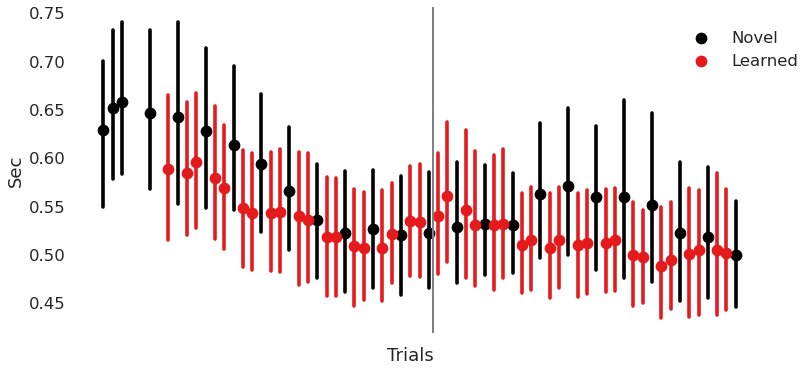

In [6]:
B_rt_d = B[B['measure']=='rt_d']

r = 5;
fig = plt.figure(figsize=(12,6));
ax = sns.pointplot(data=B_rt_d, x='Trial', y='R'+str(r), join=False, hue='Type', palette=c)
sns.despine(offset=20, trim=False, right=True, left=True, bottom=True);
ax.set_ylabel('Sec')
ax.set_xticklabels('');
ax.set_xlabel('Trials')
ax.set_xlim([0,num_trials])
ax.legend(bbox_to_anchor=(0.9, 0.95), loc=2, borderaxespad=0, frameon=False);
ax.axvline(x=(num_trials/2)+(r/2), ymin=0, ymax=1, color='gray')

plot_name = 'rt_d-trials' + ext
print(plot_name)
fig.savefig(os.path.join(Folder['Fig'], plot_name), bbox_inches = "tight")

rt_d-subs.png


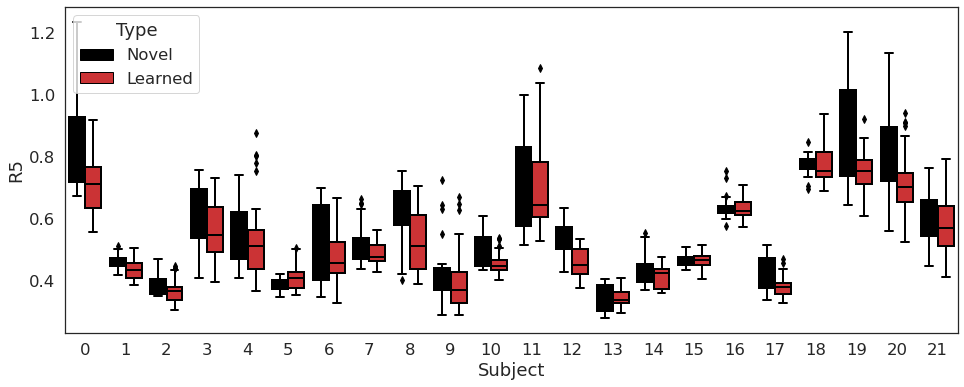

In [7]:
fig = plt.figure(figsize=(16,6))
sns.boxplot(data=B_rt_d, y='R5', x='Subject', hue='Type', palette=c)
plot_name = 'rt_d-subs' + ext
print(plot_name)
fig.savefig(os.path.join(Folder['Fig'], plot_name), bbox_inches = "tight")

<AxesSubplot:xlabel='Subject', ylabel='R5'>

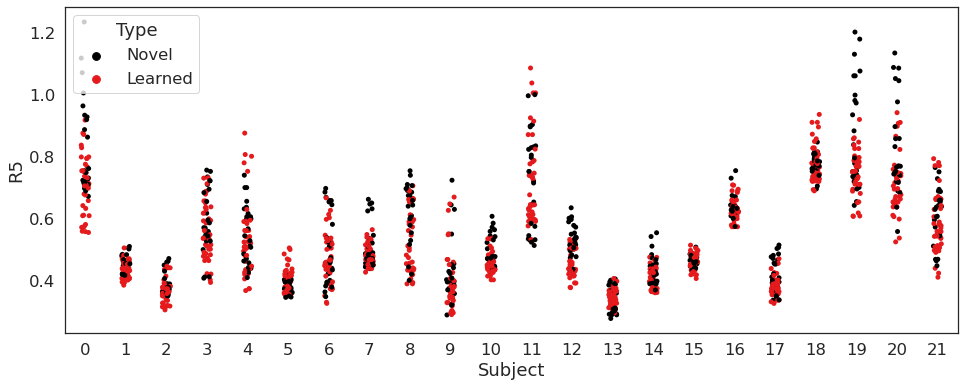

In [8]:
fig = plt.figure(figsize=(16,6))
sns.stripplot(data=B_rt_d, y='R5', x='Subject', hue='Type', palette=c)